Some initial imports, do **NOT** write any new code here:

In [2]:
import json
import torch
import numpy as np
import matplotlib.pyplot as plt

from datasets import load_dataset
from huggingface_hub import hf_hub_download

In [3]:
from plotly.subplots import make_subplots
from plotly import graph_objs as go
from sklearn.metrics import precision_score, recall_score, accuracy_score
from torchvision.transforms import Normalize

from sklearn.model_selection import StratifiedShuffleSplit
from IPython.display import display, clear_output
from collections import Counter
from tqdm import tqdm

# Question 2: ECG Beat Classification and Anomaly Detection

Electrocardiography (ECG) records the electrical activity of the heart over time using electrodes placed on the skin. ECG signals are widely used in clinical practice for detecting arrhythmias, monitoring cardiac function, and guiding diagnosis and treatment. Automated analysis of ECG signals is therefore an important application area for deep learning, with direct implications for screening, triage, and decision support.

In this question, you will work with a cleaned ECG dataset. The dataset contains **197 records** drawn from **three arrhythmia databases**. All signals have been resampled to **128 Hz**, and each recording is approximately **30 minutes** in duration. Each record is stored as a Python dictionary with the following fields:

- `patient_id`: an anonymised identifier for the patient from whom the recording was obtained.  
- `source_db`: the originating database for this record.  
- `sampling_rate`: the sampling frequency of the signal in Hz (128 for this cleaned dataset).  
- `signal`: a one-dimensional array containing the ECG time series.  
- `beat_locs`: an array of sample indices marking the onset of each annotated heartbeat in the signal.  
- `beat_labels`: an array of integer labels associated with each beat location.

Beat labels in this assessment have been mapped to a simplified index space from **0** to **4**, where **0** denotes normal beats, **1** and **2** correspond to different abnormality subclasses (supra ventricular ectopic (SVEB) and ventricular ectopic beats (VEB)), and **3** represents unknown or other beats. The exact mapping between indices and the original clinical annotation classes is provided in the accompanying file `class_mapping.json`. You should refer to this file when interpreting the label distribution and when designing your models.

This question is divided into three parts:

- **Part 2.A – Exploratory Data Analysis and Tooling**: you will perform basic exploration of the ECG signals and annotations, and construct simple plotting and preprocessing utilities to support the later tasks.  
- **Part 2.B – Classification and Anomaly Detection**: you will build a supervised deep learning model for beat-level classification, using the simplified label scheme, and explicitly examine its behaviour for normal versus abnormal beats.  
- **Part 2.C – Discussion**: you will critically discuss your modelling choices, results, limitations, and potential improvements, in a concise written analysis guided by the prompts.

You should approach these parts progressively: insights and tools developed in Part 2.A are expected to inform and support your solutions in Parts 2.B and 2.C.

<br>

---

<br>

The next few blocks of code provided in the notebook will download the dataset, load the ECG records into memory, and import the accompanying class–mapping file required for interpreting the beat labels.

In [4]:
# Use this snippet to download the dataset
dataset = load_dataset("dpelacani/ecg-led2-cleaned")

# download class_mapping.json
mapping_path = hf_hub_download(
    repo_id="dpelacani/ecg-led2-cleaned",
    filename="class_mapping.json",
    repo_type="dataset"
)

# load it
with open(mapping_path, "r") as f:
    idx_to_class = json.load(f)

print(dataset, idx_to_class)  # print dataset and mapping

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/473 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/228M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/197 [00:00<?, ? examples/s]

class_mapping.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

DatasetDict({
    train: Dataset({
        features: ['patient_id', 'source_db', 'sampling_rate', 'signal', 'beat_locs', 'beat_labels'],
        num_rows: 197
    })
}) {'0': 'NOR', '1': 'SVEB', '2': 'VEB', '3': 'UNK'}


<br><br>

## 2.A) Exploratory Data Analysis and Pre-processing

The goal of this part is to carry out a set of simple exploratory checks on the ECG dataset and to prepare the beat-level representation that will be used in later tasks. Two helper functions are provided:

- **`plot_signal`**: plots a segment of the ECG signal together with its annotated beat locations and labels.  
- **`split_by_beat`**: takes a full ECG recording and returns a list of individual beat segments based on the annotated beat locations.

Using these tools, you must complete the following:

1. **Visualise the data**  
   Use `plot_signal` to visualise a **subset of 50 consecutive beats** for **five different patients**, ensuring that beat locations and labels are annotated in the plot. These examples should give you an intuitive sense of how the signals vary across patients and beat types.

2. **Construct the beat-level dataset**  
   Use `split_by_beat` to compile a dataset where **each beat is one sample**. Build two aligned arrays/lists:
   - one containing the beat waveforms: `list[(floats)]`
   - one containing the corresponding beat labels (0–4) `list[(int)]`

3. **Apply a simple pre-processing filter**  
   Exclude beats whose durations fall outside physiologically plausible ranges. Specifically, keep only beats whose lengths fall between:  
   - **minimum length** corresponding to a **maximum heart rate of 240 bpm** (32 samples)  
   - **maximum length** corresponding to a **minimum heart rate of 30 bpm** (256 samples)  
   
   Beats outside this range should be removed, as they likely reflect annotation errors or segmentation issues.

4. **Plot summary statistics**  
   After filtering, produce two histograms:
   - one showing the **distribution of beat lengths**,  
   - one showing the **distribution of beat classes** (0–4).  

These steps should give you a clear initial understanding of the dataset and will provide the structured inputs required for the classification task in Part 2.B.

<br>

Here are the helper functions:

In [5]:
def plot_signal(
        signal,
        title="ECG Signal",
        sampling_rate=128,
        beat_locations=None,
        beat_annotations=None,
        ax = None,

    ):
    """
    Plots an ECG signal with optional anomalous beat annotations.
    Parameters:
        signal (np.ndarray): The ECG signal to plot.
        title (str): The title of the plot.
        sampling_rate (int): The sampling rate of the signal in Hz.
        beat_locations (list or np.ndarray): Indices of beat locations in the signal.
        beat_annotations (list): Annotations corresponding to the beat locations.
        ax (matplotlib.axes.Axes): Optional matplotlib axes to plot on.
    """
    if ax is None:
        _, ax = plt.subplots(figsize=(20, 5))

    time = np.arange(len(signal)) / sampling_rate / 60.
    ax.plot(time, signal)

    if beat_locations is not None:
        ax.scatter(beat_locations / sampling_rate / 60., signal[beat_locations], color='red', label='BEAT', marker='o')
        if beat_annotations is not None:
            for loc, ann in zip(beat_locations, beat_annotations):
                if ann != 'NOR':
                    ax.text(loc / sampling_rate / 60. + 0.05*np.max(time), signal[loc] + 0.05, ann, color='red', fontsize=8, weight='bold')

    ax.set_title(title)
    ax.set_xlabel("Time (min)")
    ax.set_ylabel("Normalised Amplitude")
    ax.set_ylim([-0.5, 1])
    ax.grid()

    if ax is None:
        plt.show()

In [6]:
def split_by_beat(signal, beat_locs):
    """
    Splits the ECG signal into individual beats based on beat locations.
    Parameters:
        signal (np.ndarray): The ECG signal to split.
        beat_locs (list or np.ndarray): Indices of beat locations in the signal.
    Returns:
        list: A list of individual beats extracted from the signal."""
    beats = []
    starts = [0] + beat_locs.tolist()[:-1]
    ends = beat_locs.tolist() + [len(signal)]
    for start, end in zip(starts, ends):
        beats.append(signal[start:end])
    return beats

<br>

---

<br>

Write your answer to this question below. You can use as many code and text blocks as needed.

Please, **make sure to thoroughly describe and comment every piece of code that you include in your answer**. You will be expected to understand every line of code that you write.

<br>

1. **Visualise the data**

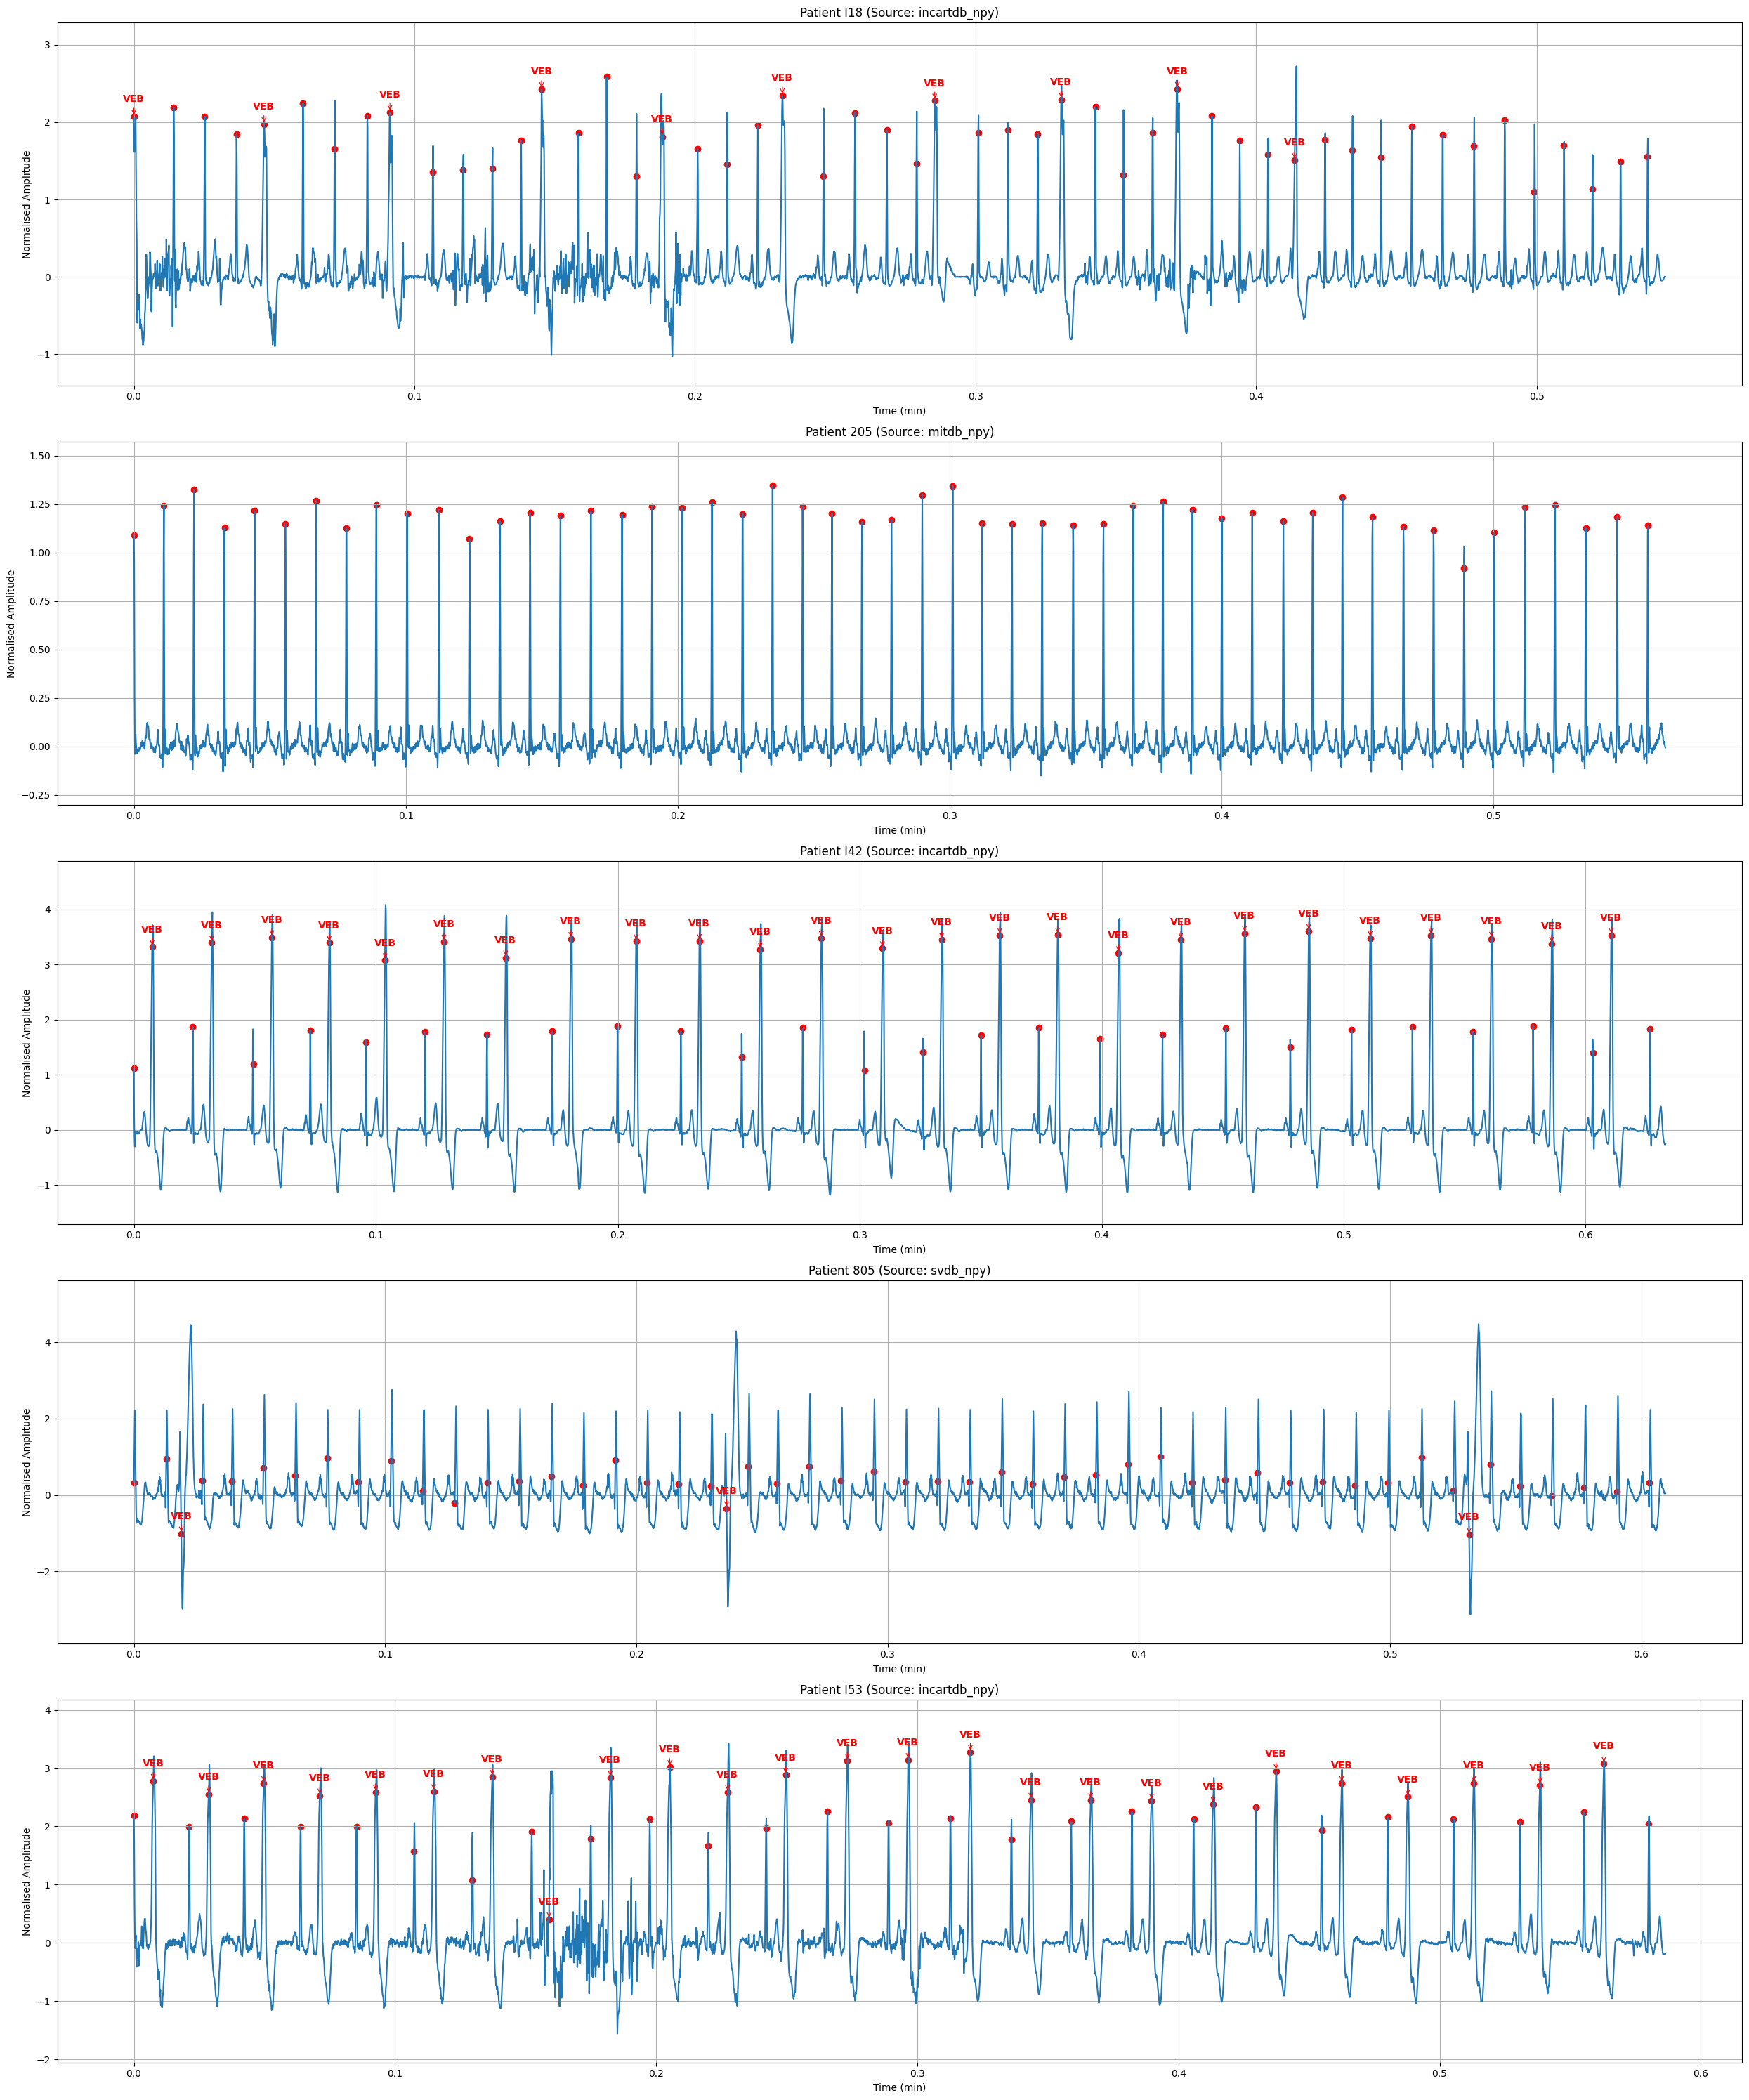

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import random


num_patients_to_plot = 5
total_len = len(dataset['train'])

# randomly select five data
indices_to_plot = random.sample(range(total_len), num_patients_to_plot)

# figure settings
fig, axes = plt.subplots(num_patients_to_plot, 1, figsize=(25, 6 * num_patients_to_plot))


for i, idx in enumerate(indices_to_plot):
    record = dataset['train'][idx]

    # Extract data
    signal = np.array(record['signal'])
    beat_locs = np.array(record['beat_locs'])
    beat_labels = np.array(record['beat_labels'])

    # Slice 50 beats (indices 10 to 60)
    start_beat_idx = 10
    end_beat_idx = 60

    if len(beat_locs) < end_beat_idx:
        continue

    # Determine sample window
    start_sample = beat_locs[start_beat_idx]
    # Add a small buffer (e.g., 50 samples) to the end so the last beat isn't cut off
    end_sample = beat_locs[end_beat_idx] + 50

    # Slice signal and adjust locations
    signal_slice = signal[start_sample:end_sample]

    mask = (beat_locs >= start_sample) & (beat_locs < end_sample)
    beat_locs_slice = beat_locs[mask] - start_sample
    beat_labels_slice = beat_labels[mask]

    # Convert labels to strings
    beat_annotations_slice = [idx_to_class[str(label)] for label in beat_labels_slice]

    ax = axes[i]

    # use help function plot_signal to plot
    plot_signal(
        signal=signal_slice,
        title=f"Patient {record['patient_id']} (Source: {record['source_db']})",
        sampling_rate=record['sampling_rate'],
        beat_locations=beat_locs_slice,
        beat_annotations=None, # set to None, as there is a small bug
        ax=ax
    )

    # plot_signal function set the ylim to (-0.5, 1), this will leave no space for the labels
    y_min, y_max = signal_slice.min(), signal_slice.max()
    margin = (y_max - y_min) * 0.1
    ax.set_ylim(y_min - margin, y_max + margin * 1.5) # arrange more space to label

    # calculate axis time
    time_axis = np.arange(len(signal_slice)) / record['sampling_rate'] / 60.

    for loc, label_str in zip(beat_locs_slice, beat_annotations_slice):
        # skip NOR label as it is the majority
        if label_str == 'NOR':
          continue
        # 在波峰上方添加带箭头的标注
        beat_time = loc / record['sampling_rate'] / 60.
        beat_amp = signal_slice[loc]

        ax.annotate(
            label_str,
            xy=(beat_time, beat_amp),
            xytext=(0, 15), # 文本显示在点上方 15 个像素偏移处
            textcoords='offset points',
            ha='center',
            color='red',
            fontweight='bold',
            arrowprops=dict(arrowstyle='->', color='red', lw=0.8)
        )

plt.tight_layout()
plt.show()

<br>

2. **Construct the beat-level dataset**

In [86]:
# Lists to store the waveform array and label of each beats
all_beats = []
all_labels = []

# Iterate over every record in the dataset
for record in tqdm(dataset['train'], desc="Processing records"):
    signal = np.array(record['signal'])
    beat_locs = np.array(record['beat_locs'])
    beat_labels = np.array(record['beat_labels'])

    # Split the signal into individual beats using the helper function
    beats = split_by_beat(signal, beat_locs)

    # Append the processed beats and labels to our master lists
    all_beats.extend(beats)
    all_labels.extend(beat_labels)

print(f"Successfully extracted {len(all_beats)} individual beats.")

Processing records: 100%|██████████| 197/197 [00:21<00:00,  9.22it/s]

Successfully extracted 461216 individual beats.


In [87]:
print("\n" + "="*40)
print("Data Construction Complete")
print("="*40)

# Basic Stats
print(f"Total extracted beats (length of all_beats): {len(all_beats)}")
print(f"Total labels (length of all_labels): {len(all_labels)}")

# Inspect a few random samples
print("\n--- Sample Inspection ---")
import random
indices_to_inspect = [0, 100, 1000]

for idx in indices_to_inspect:
    # convert numbers to string label
    if idx < len(all_beats):
        beat_len = len(all_beats[idx])
        label = all_labels[idx]
        label_str = idx_to_class[str(label)]
        print(f"Index {idx}: Label {label} ({label_str}) | Length: {beat_len} samples ({beat_len/128:.3f} sec)")

# Class Distribution
print("\n--- Class Distribution ---")
label_counts = Counter(all_labels)
for label_idx in sorted(label_counts.keys()):
    count = label_counts[label_idx]
    percentage = (count / len(all_labels)) * 100
    class_name = idx_to_class.get(str(label_idx), "Unknown")
    print(f"Class {label_idx} ({class_name}): {count} samples ({percentage:.2f}%)")


Data Construction Complete
Total extracted beats (length of all_beats): 461216
Total labels (length of all_labels): 461216

--- Sample Inspection ---
Index 0: Label 0 (NOR) | Length: 32 samples (0.250 sec)
Index 100: Label 0 (NOR) | Length: 144 samples (1.125 sec)
Index 1000: Label 0 (NOR) | Length: 141 samples (1.102 sec)

--- Class Distribution ---
Class 0 (NOR): 405800 samples (87.98%)
Class 1 (SVEB): 17308 samples (3.75%)
Class 2 (VEB): 38008 samples (8.24%)
Class 3 (UNK): 100 samples (0.02%)


<br>

3. **Apply a simple pre-processing filter**  

In [88]:
# physiological limits
min_samples = 32
max_samples = 256

filtered_beats = []
filtered_labels = []

# Counters for reporting
original_count = len(all_beats)
removed_count = 0

# Iterate the raw beats and labels
for beat, label in zip(all_beats, all_labels):
    length = len(beat)

    # Check if the beat length is within the valid range
    if min_samples <= length <= max_samples:
        filtered_beats.append(beat)
        filtered_labels.append(label)
    else:
        removed_count += 1

# Update our main variables to point to the filtered data
all_beats = filtered_beats
all_labels = filtered_labels

print(f"Filtering complete.")
print(f"Original beats: {original_count}")
print(f"Removed beats:  {removed_count} ({removed_count/original_count:.2%})")
print(f"Remaining beats: {len(all_beats)}")

Filtering complete.
Original beats: 461216
Removed beats:  331 (0.07%)
Remaining beats: 460885


<br>

4. **Plot summary statistics**

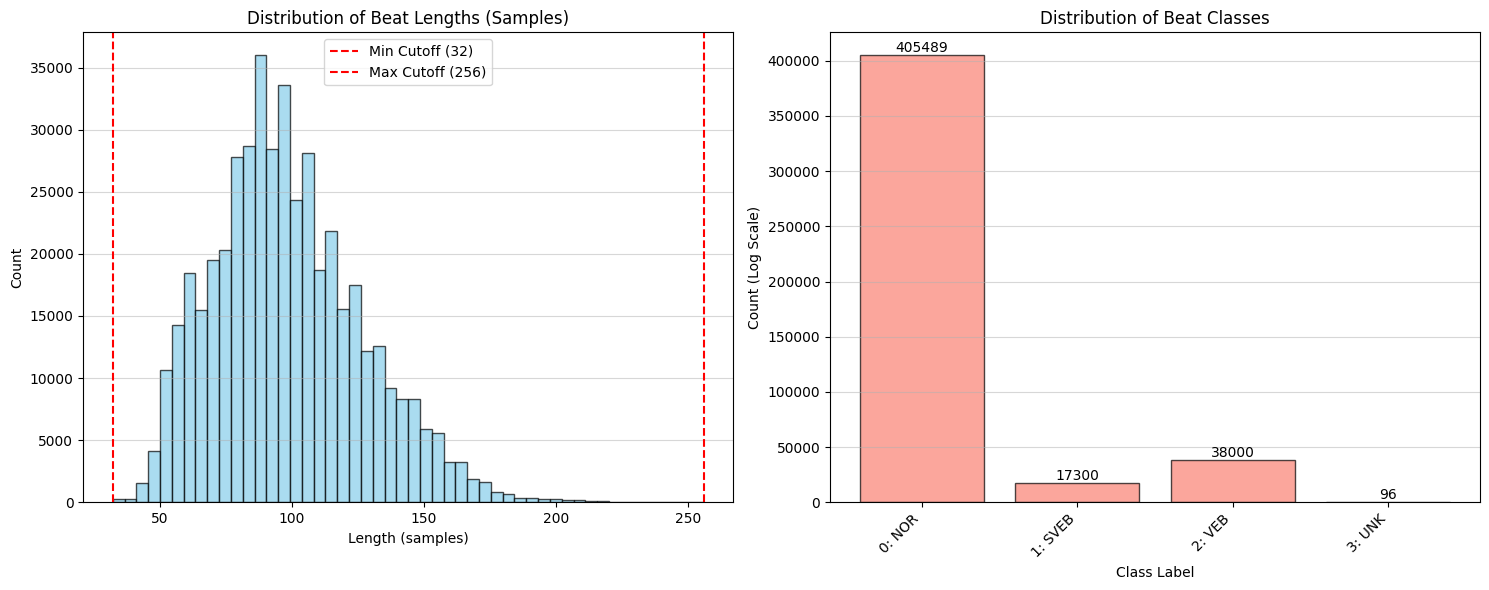

In [89]:
# 4. Plot summary statistics

# Calculate lengths for all valid beats
beat_lengths = [len(beat) for beat in all_beats]

# Count the occurrences of each class label
# We sort the keys to ensure the x-axis is ordered 0-4
label_counts = Counter(all_labels)
sorted_labels = sorted(label_counts.keys())
counts = [label_counts[l] for l in sorted_labels]

# Create mappings for x-axis ticks to make them readable
# We use the idx_to_class dictionary loaded earlier
class_names = [f"{l}: {idx_to_class[str(l)]}" for l in sorted_labels]

# Setup the figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Distribution of Beat Lengths
ax1.hist(beat_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
ax1.set_title("Distribution of Beat Lengths (Samples)")
ax1.set_xlabel("Length (samples)")
ax1.set_ylabel("Count")
# Add vertical lines for the cutoffs we used
ax1.axvline(x=32, color='red', linestyle='--', label='Min Cutoff (32)')
ax1.axvline(x=256, color='red', linestyle='--', label='Max Cutoff (256)')
ax1.legend()
ax1.grid(axis='y', alpha=0.5)

# Plot 2: Distribution of Beat Classes
bars = ax2.bar(sorted_labels, counts, color='salmon', edgecolor='black', alpha=0.7)
ax2.set_title("Distribution of Beat Classes")
ax2.set_xlabel("Class Label")
ax2.set_ylabel("Count (Log Scale)")
ax2.set_xticks(sorted_labels)
ax2.set_xticklabels(class_names, rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.5)


# Add text labels on top of the bars for clarity
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

<br><br>

## 2.B) Classification and Anomaly Detection

In this part you will build a supervised **beat-level classifier** using the segmented beats prepared in Part 2.A. Each beat is treated as an individual sample with a label in the simplified index space (0–4). Key points to consider:

- You should drop all beats with a label of **3** and only train the classifier for labels **0**, **1** and **2**. This will make the training easier, given the significant class imbalance.

- Beats naturally vary in duration, so you must decide how to convert them into a consistent representation suitable for a model. You are free to choose any reasonable approach; at the simplest level, you may choose to zero-pad beats to a fixed length, but more refined strategies are also acceptable.

- You are expected to design the full solution **yourself**: the model, the preprocessing pipeline, the train/validation splits, and the overall training procedure. You must also decide on **suitable evaluation metrics** for this problem.

- As established in Part 2.A, the dataset is **heavily imbalanced**, with normal beats dominating the distribution. This affects both training and evaluation: models that ignore imbalance tend to overfit normal beats while failing on minority abnormal classes. **Strong solutions will address imbalance explicitly and will aim to produce models that perform reliably across all classes, not only the majority one.** You are, therefore, required to report each validation metric twice: one for normal (0) and one for abnormal (1-2), separately.

- Only include code that is necessary to reproduce your results. Notebook organisation and clarity form part of the assessment (see the main *README*).

- You should ensure that the notebook clearly displays how your chosen **evaluation metric(s) evolve over training iterations or epochs.**

- You may include **up to two** solutions in this notebook, in recognition that partially working attempts may still receive marks under the criteria outlined in the *README*, but you are encouraged to start with a simple, reliable baseline before attempting a more complex model.


<br>

---

<br>

Write your answer to this question below. You can use as many code and text blocks as needed.

Please, **make sure to thoroughly describe and comment every piece of code that you include in your answer**. You will be expected to understand every line of code that you write.

<br>

In [91]:
print(len(all_beats))
# Filter out Label 3 and Normalize Inputs
valid_indices = [i for i, label in enumerate(all_labels) if label != 3]
# X_filtered: (all_beats_size, beats_length)
X_filtered = [all_beats[i] for i in valid_indices]
print(len(X_filtered))

460885
460789


In [92]:
from torch.utils.data import WeightedRandomSampler

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Filter out Label 3 and Normalize Inputs
valid_indices = [i for i, label in enumerate(all_labels) if label != 3]
# X_filtered: (all_beats_size, beats_length)
X_filtered = [all_beats[i] for i in valid_indices]
# y_filtered: (all_beats_size, 1)
y_filtered = [all_labels[i] for i in valid_indices]

# Strategy: Zero-pad all sequences to the max length defined (256)
MAX_LEN = 256

X_padded = np.zeros((len(X_filtered), MAX_LEN))
# center padding
for i, beat in enumerate(X_filtered):
    length = min(len(beat), MAX_LEN)
    start_idx = (MAX_LEN - length) // 2
    X_padded[i, start_idx : start_idx + length] = beat[:length]

y_filtered = np.array(y_filtered)

# use StratifiedShuffleSplit to ensure the rare classes (1 and 2) are
# distributed proportionally between train and validation sets.
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter.split(X_padded, y_filtered))

X_train, X_val = X_padded[train_idx], X_padded[val_idx]
y_train, y_val = y_filtered[train_idx], y_filtered[val_idx]

# (all_beats_size*0.8, 1, beats_length)
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
# (all_beats_size*0.8, 1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# (all_beats_size*0.2, 1, beats_length)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
# (all_beats_size*0.2, 1)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

batch_size = 128
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)

# calculate class counts for repeat sampling(dealing with imbalanced dataset)
class_counts = Counter(y_train)

# calcualte weights, Weight = 1.0 / Count, the larger the weights,
# the larger the possiblity that it can be assighed to the batch
weight_per_class = {cls: 1.0 / count for cls, count in class_counts.items()}

# assign weights to train
samples_weights = [weight_per_class[label] for label in y_train]
samples_weights = torch.tensor(samples_weights, dtype=torch.float)

# creaete weightedRandomSampler
sampler = WeightedRandomSampler(
    weights=samples_weights,
    num_samples=len(samples_weights),
    replacement=True
)

# modify dataloader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=sampler,  # apply sampler
    shuffle=False
)

# no need weighted sample for validation datasets
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print("WeightedRandomSampler applied to train_loader.")

Training samples: 368631
Validation samples: 92158
WeightedRandomSampler applied to train_loader.


In [93]:
import torch.nn as nn
import torch.nn.functional as F

# Model Architecture, classic CNN model
class ECGClassifier(nn.Module):
    def __init__(self, num_classes=3):
        super(ECGClassifier, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(kernel_size=2) # Reduces length 256 -> 128

        self.conv2 = nn.Conv1d(16, 32, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(kernel_size=2) # Reduces length 128 -> 64

        self.conv3 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(kernel_size=2) # Reduces length 64 -> 32

        self.fc1 = nn.Linear(64 * 32, 128)
        self.dropout = nn.Dropout(0.5) # Regularization to prevent overfitting
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1) # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [94]:
# ResNet classifier
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, kernel_size=5):
        super(ResidualBlock, self).__init__()
        padding = kernel_size // 2

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size,
                               stride=stride, padding=padding, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)

        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size,
                               stride=1, padding=padding, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)

        # Shortcut
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

    def forward(self, x):
        identity = x  # keep original input for shortcut

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += self.shortcut(identity)
        out = F.relu(out)

        return out

# model structure
class ResNetECG(nn.Module):
    def __init__(self, num_classes=3, in_channels=1):
        super(ResNetECG, self).__init__()

        self.initial_conv = nn.Sequential(
            nn.Conv1d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )

        self.layer1 = self._make_layer(64, 64, blocks=2, stride=1)
        self.layer2 = self._make_layer(64, 128, blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, blocks=2, stride=2)
        self.layer4 = self._make_layer(256, 512, blocks=2, stride=2)

        self.avg_pool = nn.AdaptiveAvgPool1d(1)

        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        # x shape: [Batch, 1, Length]
        x = self.initial_conv(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avg_pool(x)       # [Batch, 512, 1]
        x = x.view(x.size(0), -1)  # Flatten -> [Batch, 512]
        x = self.fc(x)             # [Batch, num_classes]

        return x

In [76]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from sklearn.metrics import recall_score, precision_score

# train
def train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
    history = {
        'train_loss': [], 'val_loss': [],
        'normal_f1': [], 'abnormal_f1': [],
        'normal_recall': [], 'abnormal_recall': []
    }

    print(f"Starting training on {device}...")

    for epoch in range(num_epochs):
        #  Training Phase
        model.train()
        running_loss = 0.0

        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=True)

        for inputs, labels in train_loop:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # update progress bar
            train_loop.set_postfix(loss=loss.item())

        # calculate average train loss
        epoch_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(epoch_loss)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_targets = []

        val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)

        with torch.no_grad():
            for inputs, labels in val_loop:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(labels.cpu().numpy())

        # calculate average Val Loss
        epoch_val_loss = val_loss / len(val_loader.dataset)
        history['val_loss'].append(epoch_val_loss)

        # Metrics Calculation
        all_preds = np.array(all_preds)
        all_targets = np.array(all_targets)

        # Metrics for NORMAL (Class 0)
        norm_recall = recall_score(all_targets, all_preds, labels=[0], average='macro', zero_division=0)
        norm_prec = precision_score(all_targets, all_preds, labels=[0], average='macro', zero_division=0)
        norm_f1 = 2 * (norm_prec * norm_recall) / (norm_prec + norm_recall + 1e-8)

        # Metrics for ABNORMAL (Classes 1 & 2)
        abnorm_recall = recall_score(all_targets, all_preds, labels=[1, 2], average='macro', zero_division=0)
        abnorm_prec = precision_score(all_targets, all_preds, labels=[1, 2], average='macro', zero_division=0)
        abnorm_f1 = 2 * (abnorm_prec * abnorm_recall) / (abnorm_prec + abnorm_recall + 1e-8)

        # Update History
        history['normal_f1'].append(norm_f1)
        history['abnormal_f1'].append(abnorm_f1)
        history['normal_recall'].append(norm_recall)
        history['abnormal_recall'].append(abnorm_recall)

        # Print Summary
        print(f"Epoch {epoch+1} Summary | "
              f"Train Loss: {epoch_loss:.4f} | "
              f"Val Loss: {epoch_val_loss:.4f} | "
              f"Norm F1: {norm_f1:.4f} | "
              f"Abnorm F1: {abnorm_f1:.4f}")
        print("-" * 80)

    return history

In [77]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 15

criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# CNN Baseline
print("\n=== Training Baseline Model ===")
model = ECGClassifier(num_classes=3).to(device)
# seperate optimizer for each model
optimizer_baseline = torch.optim.Adam(model.parameters(), lr=0.001)

train_history = train(
    model, train_loader, val_loader,
    criterion, optimizer_baseline, device, num_epochs
)

# ResNet
print("\n=== Training ResNet Model ===")
model_resnet = ResNetECG(num_classes=3).to(device)

# new optimizer
optimizer_resnet = torch.optim.Adam(model_resnet.parameters(), lr=0.001)

train_history_resnet = train(
    model_resnet, train_loader, val_loader,
    criterion, optimizer_resnet, device, num_epochs
)


=== Training Baseline Model ===
Starting training on cuda...


Epoch 1/15 [Train]: 100%|██████████| 2880/2880 [00:14<00:00, 195.64it/s, loss=0.0956]


Epoch 1 Summary | Train Loss: 0.1842 | Val Loss: 0.4334 | Norm F1: 0.7670 | Abnorm F1: 0.5727
--------------------------------------------------------------------------------


Epoch 2/15 [Train]: 100%|██████████| 2880/2880 [00:14<00:00, 196.35it/s, loss=0.126]


Epoch 2 Summary | Train Loss: 0.1076 | Val Loss: 0.3069 | Norm F1: 0.8831 | Abnorm F1: 0.6273
--------------------------------------------------------------------------------


Epoch 3/15 [Train]: 100%|██████████| 2880/2880 [00:14<00:00, 196.45it/s, loss=0.089]


Epoch 3 Summary | Train Loss: 0.0827 | Val Loss: 0.2823 | Norm F1: 0.8903 | Abnorm F1: 0.6174
--------------------------------------------------------------------------------


Epoch 4/15 [Train]: 100%|██████████| 2880/2880 [00:14<00:00, 199.50it/s, loss=0.111]


Epoch 4 Summary | Train Loss: 0.0690 | Val Loss: 0.3101 | Norm F1: 0.8823 | Abnorm F1: 0.6300
--------------------------------------------------------------------------------


Epoch 5/15 [Train]: 100%|██████████| 2880/2880 [00:14<00:00, 200.69it/s, loss=0.0403]


Epoch 5 Summary | Train Loss: 0.0592 | Val Loss: 0.2557 | Norm F1: 0.9196 | Abnorm F1: 0.6551
--------------------------------------------------------------------------------


Epoch 6/15 [Train]: 100%|██████████| 2880/2880 [00:13<00:00, 206.11it/s, loss=0.0455]


Epoch 6 Summary | Train Loss: 0.0520 | Val Loss: 0.2443 | Norm F1: 0.9298 | Abnorm F1: 0.6714
--------------------------------------------------------------------------------


Epoch 7/15 [Train]: 100%|██████████| 2880/2880 [00:13<00:00, 208.79it/s, loss=0.066]


Epoch 7 Summary | Train Loss: 0.0471 | Val Loss: 0.2653 | Norm F1: 0.9230 | Abnorm F1: 0.6532
--------------------------------------------------------------------------------


Epoch 8/15 [Train]: 100%|██████████| 2880/2880 [00:14<00:00, 204.26it/s, loss=0.0281]


Epoch 8 Summary | Train Loss: 0.0437 | Val Loss: 0.2628 | Norm F1: 0.9359 | Abnorm F1: 0.6739
--------------------------------------------------------------------------------


Epoch 9/15 [Train]: 100%|██████████| 2880/2880 [00:13<00:00, 207.79it/s, loss=0.0323]


Epoch 9 Summary | Train Loss: 0.0403 | Val Loss: 0.2530 | Norm F1: 0.9430 | Abnorm F1: 0.6984
--------------------------------------------------------------------------------


Epoch 10/15 [Train]: 100%|██████████| 2880/2880 [00:13<00:00, 207.59it/s, loss=0.107]


Epoch 10 Summary | Train Loss: 0.0376 | Val Loss: 0.2529 | Norm F1: 0.9495 | Abnorm F1: 0.7100
--------------------------------------------------------------------------------


Epoch 11/15 [Train]: 100%|██████████| 2880/2880 [00:13<00:00, 207.02it/s, loss=0.0199]


Epoch 11 Summary | Train Loss: 0.0354 | Val Loss: 0.2578 | Norm F1: 0.9426 | Abnorm F1: 0.6856
--------------------------------------------------------------------------------


Epoch 12/15 [Train]: 100%|██████████| 2880/2880 [00:13<00:00, 205.73it/s, loss=0.0315]


Epoch 12 Summary | Train Loss: 0.0336 | Val Loss: 0.2632 | Norm F1: 0.9505 | Abnorm F1: 0.7113
--------------------------------------------------------------------------------


Epoch 13/15 [Train]: 100%|██████████| 2880/2880 [00:14<00:00, 204.74it/s, loss=0.0158]


Epoch 13 Summary | Train Loss: 0.0321 | Val Loss: 0.2615 | Norm F1: 0.9522 | Abnorm F1: 0.7218
--------------------------------------------------------------------------------


Epoch 14/15 [Train]: 100%|██████████| 2880/2880 [00:13<00:00, 207.02it/s, loss=0.0261]


Epoch 14 Summary | Train Loss: 0.0306 | Val Loss: 0.2688 | Norm F1: 0.9515 | Abnorm F1: 0.7206
--------------------------------------------------------------------------------


Epoch 15/15 [Train]: 100%|██████████| 2880/2880 [00:13<00:00, 207.49it/s, loss=0.0195]


Epoch 15 Summary | Train Loss: 0.0288 | Val Loss: 0.2787 | Norm F1: 0.9528 | Abnorm F1: 0.7266
--------------------------------------------------------------------------------

=== Training ResNet Model ===
Starting training on cuda...


Epoch 1/15 [Train]: 100%|██████████| 2880/2880 [00:37<00:00, 77.13it/s, loss=0.158]


Epoch 1 Summary | Train Loss: 0.1459 | Val Loss: 0.2744 | Norm F1: 0.9003 | Abnorm F1: 0.5908
--------------------------------------------------------------------------------


Epoch 2/15 [Train]: 100%|██████████| 2880/2880 [00:37<00:00, 76.66it/s, loss=0.0569]


Epoch 2 Summary | Train Loss: 0.0658 | Val Loss: 0.2265 | Norm F1: 0.9288 | Abnorm F1: 0.6651
--------------------------------------------------------------------------------


Epoch 3/15 [Train]: 100%|██████████| 2880/2880 [00:35<00:00, 80.72it/s, loss=0.0205]


Epoch 3 Summary | Train Loss: 0.0441 | Val Loss: 0.2373 | Norm F1: 0.9259 | Abnorm F1: 0.6349
--------------------------------------------------------------------------------


Epoch 4/15 [Train]: 100%|██████████| 2880/2880 [00:35<00:00, 80.60it/s, loss=0.0158]


Epoch 4 Summary | Train Loss: 0.0334 | Val Loss: 0.2126 | Norm F1: 0.9501 | Abnorm F1: 0.7136
--------------------------------------------------------------------------------


Epoch 5/15 [Train]: 100%|██████████| 2880/2880 [00:35<00:00, 80.44it/s, loss=0.0236]


Epoch 5 Summary | Train Loss: 0.0268 | Val Loss: 0.2052 | Norm F1: 0.9620 | Abnorm F1: 0.7545
--------------------------------------------------------------------------------


Epoch 6/15 [Train]: 100%|██████████| 2880/2880 [00:35<00:00, 80.55it/s, loss=0.0327]


Epoch 6 Summary | Train Loss: 0.0226 | Val Loss: 0.2331 | Norm F1: 0.9594 | Abnorm F1: 0.7453
--------------------------------------------------------------------------------


Epoch 7/15 [Train]: 100%|██████████| 2880/2880 [00:37<00:00, 77.41it/s, loss=0.0021]


Epoch 7 Summary | Train Loss: 0.0194 | Val Loss: 0.1953 | Norm F1: 0.9685 | Abnorm F1: 0.7781
--------------------------------------------------------------------------------


Epoch 8/15 [Train]: 100%|██████████| 2880/2880 [00:36<00:00, 77.91it/s, loss=0.0243]


Epoch 8 Summary | Train Loss: 0.0166 | Val Loss: 0.2313 | Norm F1: 0.9700 | Abnorm F1: 0.7848
--------------------------------------------------------------------------------


Epoch 9/15 [Train]: 100%|██████████| 2880/2880 [00:36<00:00, 79.10it/s, loss=0.01]


Epoch 9 Summary | Train Loss: 0.0148 | Val Loss: 0.2211 | Norm F1: 0.9764 | Abnorm F1: 0.8109
--------------------------------------------------------------------------------


Epoch 10/15 [Train]: 100%|██████████| 2880/2880 [00:35<00:00, 80.53it/s, loss=0.0113]


Epoch 10 Summary | Train Loss: 0.0142 | Val Loss: 0.2442 | Norm F1: 0.9660 | Abnorm F1: 0.7659
--------------------------------------------------------------------------------


Epoch 11/15 [Train]: 100%|██████████| 2880/2880 [00:35<00:00, 80.30it/s, loss=0.0031]


Epoch 11 Summary | Train Loss: 0.0122 | Val Loss: 0.2241 | Norm F1: 0.9719 | Abnorm F1: 0.7928
--------------------------------------------------------------------------------


Epoch 12/15 [Train]: 100%|██████████| 2880/2880 [00:35<00:00, 80.29it/s, loss=0.00325]


Epoch 12 Summary | Train Loss: 0.0120 | Val Loss: 0.2164 | Norm F1: 0.9773 | Abnorm F1: 0.8188
--------------------------------------------------------------------------------


Epoch 13/15 [Train]: 100%|██████████| 2880/2880 [00:35<00:00, 81.15it/s, loss=0.0105]


Epoch 13 Summary | Train Loss: 0.0099 | Val Loss: 0.2496 | Norm F1: 0.9779 | Abnorm F1: 0.8212
--------------------------------------------------------------------------------


Epoch 14/15 [Train]: 100%|██████████| 2880/2880 [00:35<00:00, 81.81it/s, loss=0.00476]


Epoch 14 Summary | Train Loss: 0.0102 | Val Loss: 0.2570 | Norm F1: 0.9796 | Abnorm F1: 0.8280
--------------------------------------------------------------------------------


Epoch 15/15 [Train]: 100%|██████████| 2880/2880 [00:35<00:00, 81.62it/s, loss=0.00287]


Epoch 15 Summary | Train Loss: 0.0098 | Val Loss: 0.2358 | Norm F1: 0.9819 | Abnorm F1: 0.8427
--------------------------------------------------------------------------------


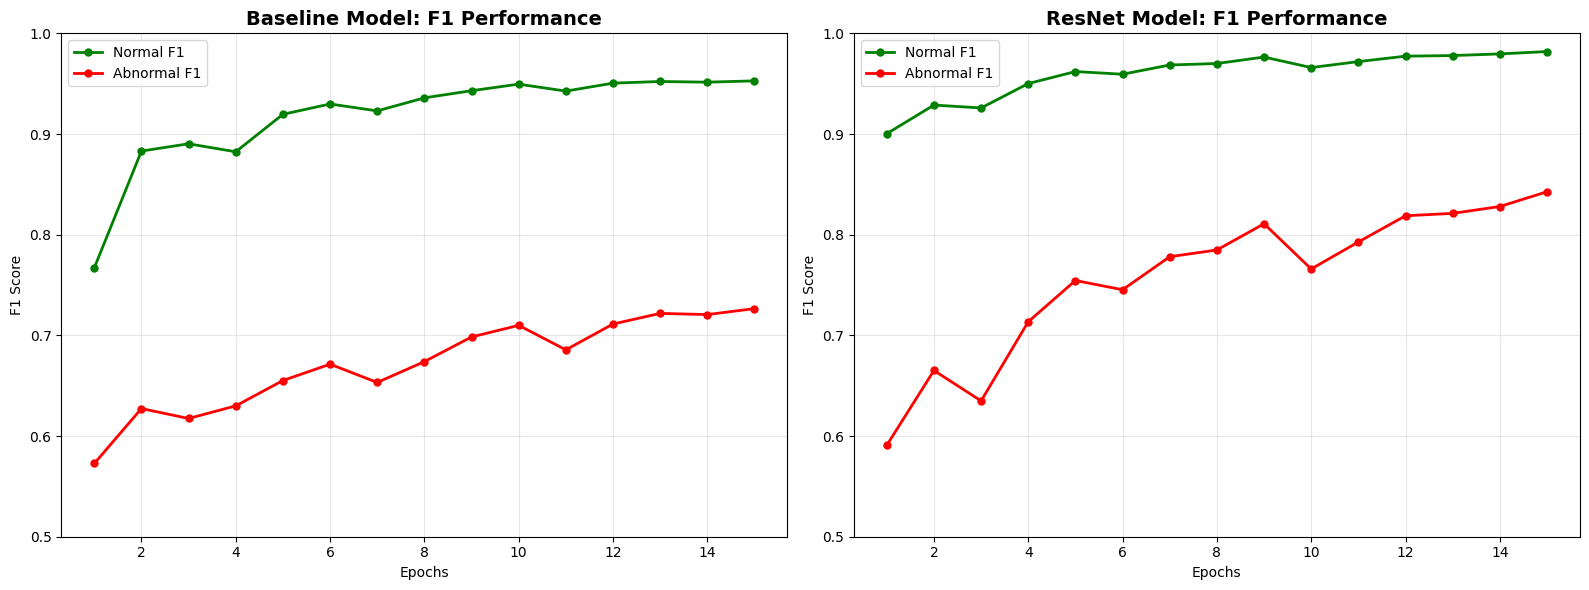

In [96]:
import matplotlib.pyplot as plt

def plot_separate_f1(history_baseline, history_resnet):
    # epochs number
    epochs = range(1, len(history_baseline['normal_f1']) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Baseline Model
    ax1 = axes[0]
    ax1.plot(epochs, history_baseline['normal_f1'], 'g-o', label='Normal F1', linewidth=2, markersize=5)
    ax1.plot(epochs, history_baseline['abnormal_f1'], 'r-o', label='Abnormal F1', linewidth=2, markersize=5)

    ax1.set_title('Baseline Model: F1 Performance', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('F1 Score')
    ax1.set_ylim(0.5, 1.0)  # set the range to 0.5-1.0
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # ResNet Model
    ax2 = axes[1]
    ax2.plot(epochs, history_resnet['normal_f1'], 'g-o', label='Normal F1', linewidth=2, markersize=5)
    ax2.plot(epochs, history_resnet['abnormal_f1'], 'r-o', label='Abnormal F1', linewidth=2, markersize=5)

    ax2.set_title('ResNet Model: F1 Performance', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('F1 Score')
    ax2.set_ylim(0.5, 1.0)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_separate_f1(train_history, train_history_resnet)

<br><br>

## 2.C) Discussion (max 250 words)

Reflect critically on your solution to Part 2.B. In your discussion, address the following points:

1. **Modelling choices**

   Explain the main decisions behind your model design(s) and why you believe these choices are suitable for this task.

2. **Performance and validation**
   
   Interpret your model’s performance on normal versus abnormal beats using the evaluation metrics you selected. Comment on how class imbalance affected the results and what strategies you have sought to mitigate its impact.

3. **Limitations and improvements**
   
   Identify the main limitations of your approach and outline specific steps that could meaningfully improve performance. You may refer to architectural changes, alternative representations, different imbalance-handling strategies, or improved validation schemes.

Your answer should be technically focused, directly address these points, and remain within the stated word limit. Overly long or off-topic discussions will be penalised.


<br>

---

<br>

// Text answer



<br>

---

<br>